Ахтемзянов Рафаэль.
Для отбора на курс Deep Learning Advanced 2023

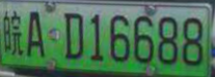

In [ ]:
import torch
import numpy as np
from collections import namedtuple
import pdb
from functools import wraps
from time import time as _timenow
from sys import stderr
import os
import pickle
import math
from PIL import Image
from operator import eq
import cv2
import random
import logging
import json
import math
from warnings import warn
import re
import string
!pip install textdistance
from textdistance import levenshtein as lev

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def similarity(word1, word2):
    return lev.normalized_distance(word1, word2)

def gmkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def corrupt(x):
    if random.random() > 0.5:
        noise = np.random.binomial(1, 1.0 - 0.2, size=x.size())
        result = x.clone()
        result  *= noise
        return result
    return x

def gaussian(images):
    if random.random() > 0.5:
        mean, var = 0, 0.1
        stddev = var**2
        noise = images.data.new(images.size()).normal_(mean, stddev)
        return images + noise
    return images

def time(f):
    @wraps(f)
    def _wrapped(*args, **kwargs):
        start = _timenow()
        result = f(*args, **kwargs)
        end = _timenow()
        print('[time] {}: {}'.format(f.__name__, end - start),
              file=stderr)
        return result

    return _wrapped


def split(samples, **kwargs):
    total = len(samples)
    indices = list(range(total))
    if kwargs['random']:
        np.random.shuffle(indices)
    percent = kwargs['split']
    # Split indices
    current = 0
    train_count = np.int(percent * total)
    train_indices = indices[current:current + train_count]
    current += train_count
    test_indices = indices[current:]
    train_subset, test_subset = [], []
    for i in train_indices:
        train_subset.append(samples[i])

    for i in test_indices:
        test_subset.append(samples[i])
    return train_subset, test_subset

def text_align(prWords, gtWords):
    row, col = len(prWords), len(gtWords)
    adjMat= np.zeros((row, col), dtype=float)
    for i in range(len(prWords)):
        for j in range(len(gtWords)):
            adjMat[i, j] = similarity(prWords[i], gtWords[j])
    pr_aligned=[]
    for i in range(len(prWords)):
        nn = list(map(lambda x:gtWords[x], np.argsort(adjMat[i, :])[:1])) 
        pr_aligned.append((prWords[i], nn[0]))
    return pr_aligned

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, save_file, patience=5, verbose=False, delta=0, best_score=None):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = best_score
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.save_file = save_file
        print(best_score)

    def __call__(self, val_loss, epoch, model, optimizer):
        
        score = -val_loss
        state = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'opt_state_dict': optimizer.state_dict(),
                'best': score
                }
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, state)
        elif score < self.best_score - self.delta:

            self.counter += 1
            print(f'EarlyStopping counter: ({self.best_score:.6f} {self.counter} out of {self.patience})')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, state)
            self.counter = 0

    def save_checkpoint(self, val_loss, state):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(state, self.save_file)
        self.val_loss_min = val_loss


class AverageMeter:
    def __init__(self, name):
        self.name = name
        self.count = 0
        self.total = 0
        self.max = -1 * float("inf")
        self.min = float("inf")

    def add(self, element):
        # pdb.set_trace()
        self.total += element
        self.count += 1
        self.max = max(self.max, element)
        self.min = min(self.min, element)

    def compute(self):
        # pdb.set_trace()
        if self.count == 0:
            return float("inf")
        return self.total / self.count

    def __str__(self):
        return "%s (min, avg, max): (%.3lf, %.3lf, %.3lf)" % (self.name, self.min, self.compute(), self.max)

class Eval:
    def _blanks(self, max_vals,  max_indices):
        def get_ind(indices):
            result = []
            for i in range(len(indices)):
                if indices[i] != 0:
                    result.append(i)
            return result
        non_blank = list(map(get_ind, max_indices))
        scores = []

        for i, sub_list in enumerate(non_blank):
            sub_val = []
            if sub_list:
                for item in sub_list:
                    sub_val.append(max_vals[i][item])
            score = np.exp(np.sum(sub_val))
            if math.isnan(score):
                score = 0.0
            scores.append(score)
        return scores


    def _clean(self, word):
        regex = re.compile('[%s]' % re.escape('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”„'))
        return regex.sub('', word)

    def char_accuracy(self, pair):
        words, truths = pair
        words, truths = ''.join(words), ''.join(truths)
        sum_edit_dists = lev.distance(words, truths)
        sum_gt_lengths = sum(map(len, truths))
        fraction = 0
        if sum_gt_lengths != 0:
            fraction = sum_edit_dists / sum_gt_lengths

        percent = fraction * 100
        if 100.0 - percent < 0:
            return 0.0
        else:
            return 100.0 - percent

    def word_accuracy(self, pair):
        correct = 0
        word, truth = pair
        if self._clean(word) == self._clean(truth):
            correct = 1
        return correct

    def format_target(self, target, target_sizes):
        target_ = []
        start = 0
        for size_ in target_sizes:
            target_.append(target[start:start + size_])
            start += size_
        return target_

    def word_accuracy_line(self, pairs):
        preds, truths = pairs
        word_pairs = text_align(preds.split(), truths.split())
        word_acc = np.mean((list(map(self.word_accuracy, word_pairs))))
        return word_acc

class OCRLabelConverter(object):
    """Convert between str and label.

    NOTE:
        Insert `blank` to the alphabet for CTC.

    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=False):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1
        self.dict[''] = 0
    def encode(self, text):
        """Support batch or single str.

        Args:
            text (str or list of str): texts to convert.

        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        '''
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))
        '''
        length = []
        result = []
        for item in text:
            # item = item.decode('utf-8', 'strict')
            length.append(len(item))
            for char in item:
                if char in self.dict:
                    index = self.dict[char]
                else:
                    index = 0
                result.append(index)

        text = result
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.

        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.

        Raises:
            AssertionError: when the texts and its length does not match.

        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(),
                                                                                                         length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(
                t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import pdb
import six
import random
import lmdb
from PIL import Image
import numpy as np
import math
from collections import OrderedDict
from itertools import chain
import logging


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split
sys.path.insert(0, '../')
from tqdm import *

# Часть 1: Подготовка данных

In [ ]:
# Подключаем диск
from google.colab import drive
drive.mount('/content/drive')

# Разархивируем картинки, предварительно загруженные на гугл-диск
!unzip /content/drive/MyDrive/CCPD2019-dl1.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: CCPD2019-dl1/train/0162176724138-皖AZH956.jpg  
 extracting: CCPD2019-dl1/train/0228987068966-皖A09Z87.jpg  
 extracting: CCPD2019-dl1/train/0148263888889-皖AA1858.jpg  
 extracting: CCPD2019-dl1/train/0143534482759-皖A0Z639.jpg  
 extracting: CCPD2019-dl1/train/0168965517241-皖A7A666.jpg  
 extracting: CCPD2019-dl1/train/0102370689655-皖AN276A.jpg  
 extracting: CCPD2019-dl1/train/0129992816092-皖AH7513.jpg  
 extracting: CCPD2019-dl1/train/0318151340996-皖ABD019.jpg  
 extracting: CCPD2019-dl1/train/0123563218391-皖A1N172.jpg  
 extracting: CCPD2019-dl1/train/0113314176245-皖A22A63.jpg  
 extracting: CCPD2019-dl1/train/0088912835249-皖AC586U.jpg  
 extracting: CCPD2019-dl1/train/017966954023-皖HVU529.jpg  
 extracting: CCPD2019-dl1/train/0178999042145-皖AH709M.jpg  
 extracting: CCPD2019-dl1/train/0146228448276-皖AV168Y.jpg  
 extracting: CCPD2019-dl1/train/0263409961686-皖AG410G.jpg  
 extracting: CCPD2019-dl1/train/0

In [ ]:
# Пропишем класс для датасэтов

import os
import cv2
import torch
import torch.utils.data as data
import numpy as np

class PlateRecognitionDataset(data.Dataset):
    def __init__(self, root_dir, size=(64, 32)):
        self.root_dir = root_dir
        self.size = size
        self.images = []
        self.labels = []

        # Считываем картинки из директории
        for file_name in os.listdir(root_dir):
            file_path = os.path.join(root_dir, file_name)
            image = cv2.imread(file_path)
            image = cv2.resize(image, self.size)
            label = file_name.split('_')[0]
            self.images.append(np.transpose(image, (2, 0, 1))) #ndarray
            self.labels.append(label.split('-')[1].split('.')[0]) #str

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = torch.from_numpy(np.array(self.images[idx])).cuda() # torch tensor
        label = self.labels[idx] # list of strings
      
        return {'img': image, 'label': label, 'idx': idx}




In [ ]:
class SynthCollator(object):
    
    def __call__(self, batch):
        width = [item['img'].shape[2] for item in batch]
        indexes = [item['idx'] for item in batch]
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], batch[0]['img'].shape[1], 
                           max(width)], dtype=torch.float32).cuda()
        for idx, item in enumerate(batch):
            try:
                imgs[idx, :, :, 0:item['img'].shape[2]] = item['img'].cuda()
            except:
                print(imgs.shape)
        item = {'img': imgs, 'idx':indexes}
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        return item

In [ ]:
# # Тренировочный датасэт
# train_dataset = PlateRecognitionDataset('/content/CCPD2019-dl1/train')
# # Тестовый датасэт (он же в данном случае валидационный)
# val_dataset = PlateRecognitionDataset('/content/CCPD2019-dl1/test')

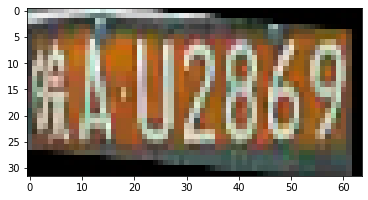

Всего 199980 картинок в train
Номер на этой картинке: 皖AU2869


In [ ]:
# # Нарисуем случайную кратинку 

# import matplotlib.pyplot as plt

# # Выбираем рандомный индекс
# idx = np.random.randint(0, len(train_dataset))
# item = train_dataset[idx]

# # Отображаем
# image = item['img']
# plt.imshow(image.cpu().detach().numpy())
# plt.show()

# # Ещё немного инфо
# print(f'Всего {len(train_dataset)} картинок в train')
# true_label = item['label']
# print(f'Номер на этой картинке: {true_label}')

In [ ]:
image.shape

torch.Size([32, 64, 3])

In [ ]:
# Токенизируем символы
s = ''
for num in train_dataset[:]['label']:
  s += num 
all_tokens = list(set(s))
''.join(all_tokens)

'XKR4浙09宁P皖豫贵鲁C粤蒙桂沪6L琼藏2京HB辽ODU云3J5S陕8赣青黑甘FZW川新AEQ渝VG冀吉Y7NT湘晋1苏鄂闽M津'

# Часть 2: Создание и обучение модели

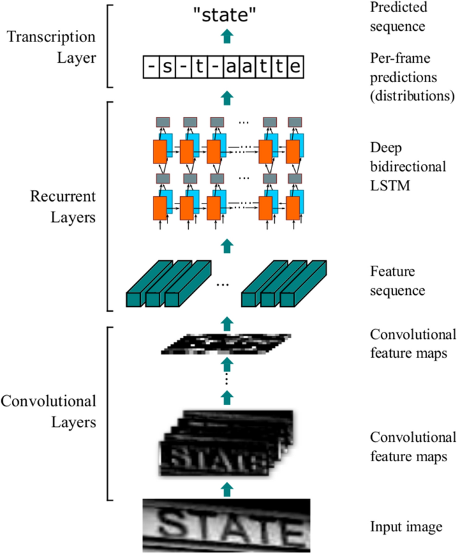

In [ ]:
# Статья, в которой была предложена эта архитектура: https://arxiv.org/pdf/1507.05717.pdf
# Код по мотивам статьи: https://deepayan137.github.io/blog/markdown/2020/08/29/building-ocr.html

In [ ]:
# Пропишем кастомный CTC лосс

import math

class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

In [ ]:
# Модель в Pytorch для распознавания текста на картинке 

import torch
import torch.nn as nn

class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output


In [ ]:
# Класс для обучения модели:


class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def _run_batch(self, batch, report_accuracy=False, validation=False):
        input_, targets = batch['img'], batch['label']
        targets, lengths = self.converter.encode(targets)
        logits = self.forward(input_)
        logits = logits.contiguous().cpu()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
        return loss, ca, wa

    def run_epoch(self, validation=False):
        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

    def training_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        self.optimizer.zero_grad()
        loss.backward()
        self.step()
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        return output

    def validation_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
        output = OrderedDict({
            'val_loss': abs(loss.item()),
            'val_ca': ca.item(),
            'val_wa': wa.item()
            })
        return output

    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,
        'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,
        'val_wa': val_wa_mean}
        return result

In [ ]:
# ! pip install torchmetrics
# import torch.optim as optim
# from torchmetrics import CharErrorRate
# from sklearn.metrics import accuracy_score

# # Обучение модели
# # Проверяем наличие GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Даталодеры
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

# # Инициализируем модель
# model = PlateRecognitionModel(num_chars=66).to(device)

# # Оптимайзер и функция потерь, всё стандартно
# optimizer = optim.Adam(model.parameters())
# loss_fn = nn.CrossEntropyLoss()

# # Цикл обучения

# num_epochs = 3
# # Train the model for a given number of epochs
# for epoch in range(num_epochs):
#     for images, labels in train_loader:
#         images = images.to(device)
#         labels = torch.tensor([[tokenizer.transform(list(label))] for label in labels])

#         # Forward pass
#         logits = model(images)
#         loss = loss_fn(logits.view(-1, 66), labels.view(-1))
        
#         # Backward pass and optimization step
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
    
#     # Validation loop

#     val_pred = []
#     val_fact = []

#     for images, labels in val_loader:
#         # Move images and labels to GPU if available
#         if torch.cuda.is_available():
#             images = images.to(device)
#             labels = torch.tensor([[tokenizer.transform(list(label))] for label in labels])
#         # Forward pass
#         logits = model(images)
        
#         # Compute accuracy
#         _, predictions = logits.max(dim=2).cpu().detach().numpy()

#         val_pred.append(predictions)
#         val_fact.append(labels)


#     print(f'val accuracy: {accuracy_score(val_fact, val_pred)}')
#     print(f'val CER: {CharErrorRate(val_pred, val_fact)}')

In [ ]:
# Класс, который всё собирает вместе

class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best.ckpt')
        self.cuda = torch.cuda.is_available() 
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
        self.epoch = 0
        if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score=self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %(opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(self.savepath, patience=15, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)
        
        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f'%(epoch, train_result['train_loss'], 
                val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                train_result['train_wa'], val_result['val_wa'])
            logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        print('Loading checkpoint at {} trained for {} epochs'.format(self.savepath, self.checkpoint['epoch']))
        self.model.load_state_dict(self.checkpoint['state_dict'])
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'])

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)

In [ ]:
# Гиперпараметры

alphabet = """ XKR4浙09宁P皖豫贵鲁C粤蒙桂沪6L琼藏2京HB辽ODU云3J5S陕8赣青黑甘FZW川新AEQ渝VG冀吉Y7NT湘晋1苏鄂闽M津"""
args = {
    'name':'exp1',
    'path':'/content/CCPD2019-dl1/',
    'imgdir': 'train',
    'imgH':32,
    'nChannels':3,
    'nHidden':256,
    'nClasses':len(alphabet),
    'lr':0.001,
    'epochs':4,
    'batch_size':32,
    'save_dir':'/checkpoints/',
    'log_dir':'/logs',
    'resume':False,
    'cuda':False,
    'schedule':False
    
}

data = PlateRecognitionDataset('/content/CCPD2019-dl1/train')
args['collate_fn'] = SynthCollator()
train_split = int(0.8*len(data))
val_split = len(data) - train_split
args['data_train'], args['data_val'] = random_split(data, (train_split, val_split))
print('Traininig Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train']), len(args['data_val'])))
args['alphabet'] = alphabet
model = CRNN(args)
args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
gmkdir(savepath)
gmkdir(args['log_dir'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
learner.fit(args)

Traininig Data Size:159984
Val Data Size:39996
checkpoint does not exist
None
Scheduling is False


Validating: 100%|██████████| 1250/1250 [00:27<00:00, 45.54it/s, val_loss=0.0277, val_ca=99, val_wa=0.929]


0.01926843832820887
Validation loss decreased (inf --> 0.019268).  Saving model ...


Validating: 100%|██████████| 1250/1250 [00:26<00:00, 47.08it/s, val_loss=0.000192, val_ca=100, val_wa=1]


0.01690991853880696
Validation loss decreased (0.019268 --> 0.016910).  Saving model ...


Validating: 100%|██████████| 1250/1250 [00:26<00:00, 47.31it/s, val_loss=6.6e-5, val_ca=100, val_wa=1]


0.014432835307246811
Validation loss decreased (0.016910 --> 0.014433).  Saving model ...


Validating: 100%|██████████| 1250/1250 [00:26<00:00, 47.57it/s, val_loss=0.000111, val_ca=100, val_wa=1]


0.01346585909485184
Validation loss decreased (0.014433 --> 0.013466).  Saving model ...


# Часть 3: Оценка качества

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def get_accuracy(args):
    loader = torch.utils.data.DataLoader(args['data'],
                batch_size=args['batch_size'],
                collate_fn=args['collate_fn'])
    model = args['model']
    model.eval()
    converter = OCRLabelConverter(args['alphabet'])
    evaluator = Eval()
    labels, predictions, images = [], [], []
    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch['img'].to(device), batch['label']
        images.extend(input_.squeeze().detach())
        labels.extend(targets)
        targets, lengths = converter.encode(targets)
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        predictions.extend(sim_preds)
        
#     make_grid(images[:10], nrow=2)
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    pairs = list(zip(images, predictions))
    indices = np.random.permutation(len(pairs))
    for i in range(1, columns*rows +1):
        img = images[indices[i]]
        img = (img - img.min())/(img.max() - img.min())
        img = np.array(img.cpu() * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[indices[i]])
        plt.axis('off')
        plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    ca = np.mean((list(map(evaluator.char_accuracy, list(zip(predictions, labels))))))
    wa = np.mean((list(map(evaluator.word_accuracy_line, list(zip(predictions, labels))))))
    return ca, wa


Loading model /checkpoints/exp1/best.ckpt


100%|██████████| 313/313 [00:05<00:00, 56.38it/s]
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 30358 missing from current font.
  font.set_text(s, 0, flags=flags)


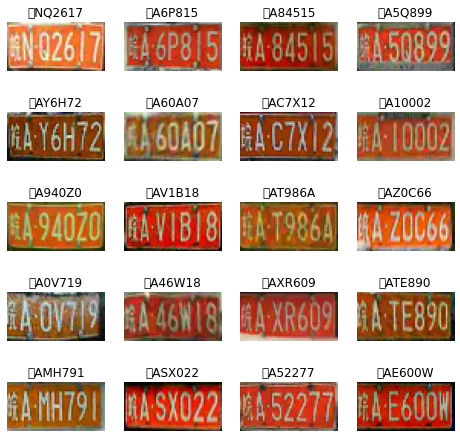

Character Accuracy: 99.18
Word Accuracy: 0.96


In [ ]:
args['imgdir'] = 'test'
args['data'] = PlateRecognitionDataset('/content/CCPD2019-dl1/test')
resume_file = os.path.join(args['save_dir'], args['name'], 'best.ckpt')
if os.path.isfile(resume_file):
    print('Loading model %s'%resume_file)
    checkpoint = torch.load(resume_file)
    model.load_state_dict(checkpoint['state_dict'])
    args['model'] = model
    ca, wa = get_accuracy(args)
    print("Character Accuracy: %.2f\nWord Accuracy: %.2f"%(ca, wa))
else:
    print('Exiting')